<a href="https://colab.research.google.com/github/preritt/Udacity-AIND/blob/master/Modified_Autoencoder_Code_for_Basic_Gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [0]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [3]:
X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
Z = tf.placeholder(tf.float32, shape=[None, 784])

G_W1 = tf.Variable(xavier_init([784, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 128]))
G_b2 = tf.Variable(tf.zeros(shape=[128]))

G_W3 = tf.Variable(xavier_init([128, 128]))
G_b3 = tf.Variable(tf.zeros(shape=[128]))

G_W4 = tf.Variable(xavier_init([128, 784]))
G_b4 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2, G_W3, G_b3,G_W4, G_b4]

In [0]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [0]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2) # encoded value
    G_h3 = tf.nn.relu(tf.matmul(G_h2, G_W3) + G_b3)
    logits = tf.matmul(G_h3, G_W4) + G_b4
    G_prob = tf.nn.sigmoid(logits)

    return G_prob, logits

In [0]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [0]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [0]:
G_fake_decoded_prob, G_fake_decoded_logits = generator(X)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_fake_decoded_prob)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

In [0]:
# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

recon_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_fake_decoded_logits, labels=X))
G_loss = G_loss + 20*recon_loss

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)


In [47]:
mb_size = 128
Z_dim = 784

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
i=0

In [0]:
for it in range(50000):
    X_mb, _ = mnist.train.next_batch(mb_size)
#     z_mb = np.random.randn(mb_size, z_dim)

#     _, recon_loss_curr = sess.run([G_solver, recon_loss], feed_dict={X: X_mb})
    _, D_loss_curr, recon_loss_curr = sess.run([D_solver, D_loss, recon_loss], feed_dict={X: X_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter: {}; D_loss: {:.4}; G_loss: {:.4}; Recon_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr, recon_loss_curr))

        samples = sess.run(G_fake_decoded_prob, feed_dict={X: np.reshape(X_mb[1], newshape=(1,-1))})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Iter: 0; D_loss: 2.175; G_loss: 15.86; Recon_loss: 0.7141
Iter: 1000; D_loss: 1.365; G_loss: 2.735; Recon_loss: 0.09787
Iter: 2000; D_loss: 1.344; G_loss: 2.332; Recon_loss: 0.08106
Iter: 3000; D_loss: 1.388; G_loss: 2.31; Recon_loss: 0.08006
Iter: 4000; D_loss: 1.365; G_loss: 2.228; Recon_loss: 0.0749
Iter: 5000; D_loss: 1.372; G_loss: 2.218; Recon_loss: 0.07473
Iter: 6000; D_loss: 1.371; G_loss: 2.169; Recon_loss: 0.073
Iter: 7000; D_loss: 1.363; G_loss: 2.15; Recon_loss: 0.07273
Iter: 8000; D_loss: 1.394; G_loss: 2.177; Recon_loss: 0.07312
Iter: 9000; D_loss: 1.39; G_loss: 2.193; Recon_loss: 0.0734
Iter: 10000; D_loss: 1.361; G_loss: 2.101; Recon_loss: 0.07009
Iter: 11000; D_loss: 1.363; G_loss: 2.203; Recon_loss: 0.07477
Iter: 12000; D_loss: 1.359; G_loss: 2.209; Recon_loss: 0.07394
Iter: 13000; D_loss: 1.373; G_loss: 2.173; Recon_loss: 0.07221
Iter: 14000; D_loss: 1.364; G_loss: 2.15; Recon_loss: 0.07178
Iter: 15000; D_loss: 1.358; G_loss: 2.147; Recon_loss: 0.07191
Iter: 16000; D

In [0]:
i = 0

DlossesTrack = []
GlossesTrack = []
losses = []
for it in range(50000):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={X: sample_Z(16, Z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})
#     print(D_loss)
#     losses.append((D_loss_curr, G_loss_curr))
#     DlossesTrack.append(D_loss_curr)
#     GlossesTrack.append(G_loss)
    if it % 1000 == 0:
        losses.append((D_loss_curr, G_loss_curr))
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D loss: 0.6405
G_loss: 2.151

Iter: 1000
D loss: 0.5933
G_loss: 2.45

Iter: 2000
D loss: 0.7804
G_loss: 2.524

Iter: 3000
D loss: 0.7889
G_loss: 2.288

Iter: 4000
D loss: 0.607
G_loss: 2.346

Iter: 5000
D loss: 0.7482
G_loss: 2.442

Iter: 6000
D loss: 0.5621
G_loss: 2.403

Iter: 7000
D loss: 0.7113
G_loss: 2.499

Iter: 8000
D loss: 0.652
G_loss: 2.107

Iter: 9000
D loss: 0.5281
G_loss: 2.172

Iter: 10000
D loss: 0.5741
G_loss: 2.146

Iter: 11000
D loss: 0.545
G_loss: 2.338

Iter: 12000
D loss: 0.5209
G_loss: 2.419

Iter: 13000
D loss: 0.6842
G_loss: 2.366

Iter: 14000
D loss: 0.57
G_loss: 2.397

Iter: 15000
D loss: 0.5508
G_loss: 2.192

Iter: 16000
D loss: 0.6118
G_loss: 2.362

Iter: 17000
D loss: 0.5899
G_loss: 1.984

Iter: 18000
D loss: 0.5487
G_loss: 2.096

Iter: 19000
D loss: 0.5302
G_loss: 2.218

Iter: 20000
D loss: 0.5349
G_loss: 2.215

Iter: 21000
D loss: 0.5996
G_loss: 2.315

Iter: 22000
D loss: 0.5132
G_loss: 2.336

Iter: 23000
D loss: 0.625
G_loss: 2.738

Iter: 24000


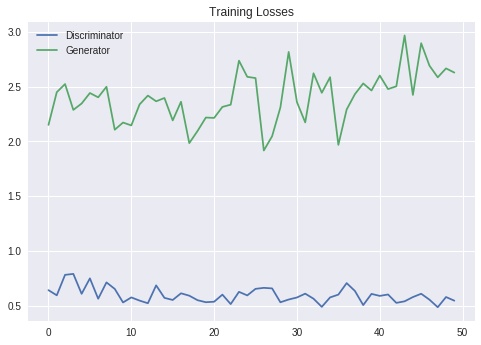

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

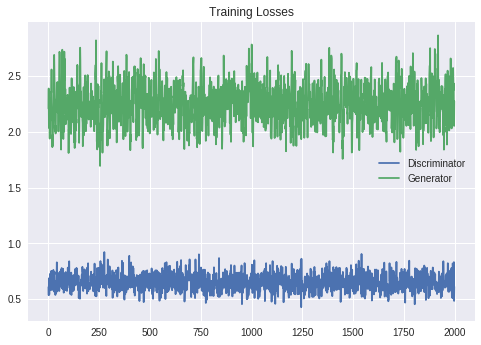

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()